In [194]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from scipy.stats import zscore

In [195]:
california_housing = fetch_california_housing(as_frame=True)

data = california_housing['frame']
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [196]:
target = data.pop('MedHouseVal')
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


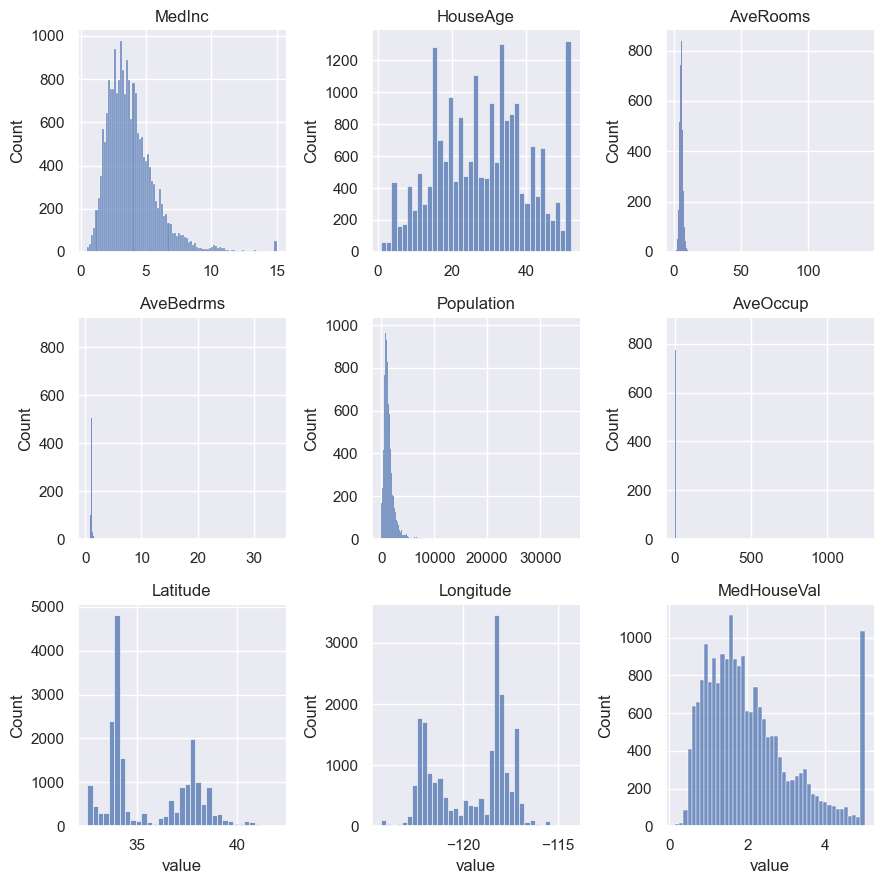

In [198]:
sns.set_theme()

melted = pd.concat([data, target], axis=1).melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

In [199]:
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
data[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


In [200]:
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
z_scores = data[features_of_interest].apply(zscore)
data_cleaned = pd.concat([data, target], axis=1)[(z_scores.abs() < 3).all(axis=1)]
data_cleaned[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20135.000000,20135.000000,20135.000000,20135.000000
mean,5.290628,1.068428,2.931787,1340.091631
std,1.270173,0.135177,0.885646,812.564686
min,0.846154,0.333333,0.750000,3.000000
25%,4.433389,1.004963,2.429156,788.000000
50%,5.212810,1.047859,2.817582,1158.000000
75%,6.017266,1.097856,3.280652,1692.000000
max,12.500000,2.514610,33.952941,4819.000000


In [201]:
target_cleaned = data_cleaned.pop('MedHouseVal')
target_cleaned.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

<Axes: >

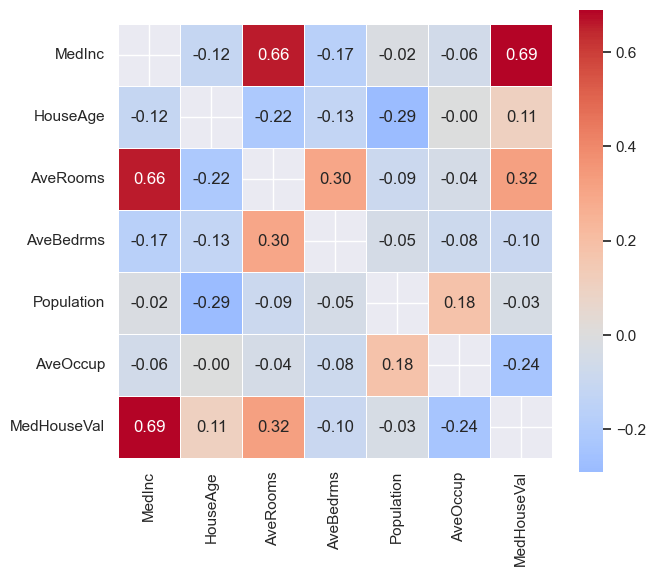

In [202]:
columns_drop = ['Longitude', 'Latitude']
subset = pd.concat([data_cleaned, target_cleaned], axis=1).drop(columns=columns_drop)

corr_mtx = subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(corr_mtx,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

Видалимо ознаку AveRooms, оскільки вона має найбільшу кореляцію

In [203]:
data_cleaned = data_cleaned.drop(columns=['AveRooms'])

In [204]:
X_train, X_test, y_train, y_test = train_test_split(
    data_cleaned,
    target_cleaned,
    test_size=0.2,
    random_state=42)

In [205]:
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [206]:
X_train_scaled.describe()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04
mean,-1.676224e-17,-1.248346e-16,1.764447e-17,-1.060874e-16,-3.793561e-17,-1.722100e-15,-8.151744e-16
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.773858e+00,-2.240869e+00,-5.444216e+00,-1.644220e+00,-2.448193e+00,-1.450260e+00,-2.367900e+00
25%,-6.876112e-01,-7.974045e-01,-4.671025e-01,-6.811515e-01,-5.624555e-01,-7.992891e-01,-1.106958e+00
50%,-1.764550e-01,4.520411e-03,-1.525954e-01,-2.266418e-01,-1.286644e-01,-6.447421e-01,5.377489e-01
75%,4.568290e-01,6.460603e-01,2.172224e-01,4.354681e-01,3.899295e-01,9.709764e-01,7.869470e-01
max,5.862520e+00,1.848948e+00,1.070880e+01,4.271775e+00,3.487352e+01,2.951988e+00,2.511397e+00


In [207]:
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

ymin, ymax = y_train.agg(['min', 'max']).values

y_pred = pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)
y_pred.head()

7969     2.415358
17082    2.745517
5623     1.710072
16934    2.593909
7501     1.638296
dtype: float64

In [208]:
r_sq = model.score(X_train_scaled, y_train)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.64 | MAE: 0.50 | MAPE: 0.29


### Порівняння з попередньою моделлю:
- R² (+0.03):
Зростання показника на 3% свідчить про те, що нова модель краще враховує фактори, які впливають на залежну змінну.
- MAE (-0.02):
Зниження абсолютної помилки говорить про те, що прогнозні значення ближчі до реальних.
- MAPE (-0.02):
Зниження відносної помилки означає, що модель покращила точність прогнозу у відносних показниках.
### Висновок:
Нова модель краща за всіма метриками. Хоча поліпшення незначне, воно свідчить про більш точне передбачення та зменшення помилок. Поточна модель є більш ефективною, особливо якщо навіть невеликі покращення можуть бути важливими для практичного застосування.

### Поліноміальна регресія

In [209]:
# [a, b] -> [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2).set_output(transform='pandas')

Xtr = poly.fit_transform(X_train_scaled)
Xts = poly.transform(X_test_scaled)

model_upd = LinearRegression().fit(Xtr, y_train)
y_pred_upd = model_upd.predict(Xts)
y_pred_upd = pd.Series(y_pred_upd, index=Xts.index).clip(ymin, ymax)

r_sq_upd = model_upd.score(Xtr, y_train)
mae_upd = mean_absolute_error(y_test, y_pred_upd)
mape_upd = mean_absolute_percentage_error(y_test, y_pred_upd)

print(f'R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}')

R2: 0.69 | MAE: 0.46 | MAPE: 0.26


### Порівняння поточної моделі з поліноміальною регресією:
- R² (0.64 vs. 0.69):
    Поліноміальна регресія має на 5% кращий коефіцієнт детермінації, що свідчить про більшу точність у поясненні залежної змінної.
- MAE (0.50 vs. 0.46):
    Поліноміальна регресія показує меншу середню абсолютну помилку, що свідчить про її перевагу в прогнозуванні.
- MAPE (0.29 vs. 0.26):
    Поліноміальна регресія має на 3% кращий показник, що підкреслює її точність у відносних прогнозах.
### Загальний висновок:
Поліноміальна регресія є найкращою серед розглянутих моделей за всіма метриками. Однак варто врахувати такі аспекти:

Поліноміальна регресія може бути складнішою в інтерпретації через нелінійність.
Можлива проблема перенавчання (overfitting), особливо якщо модель має багато ступенів поліному.
Якщо точність є ключовим критерієм, то поліноміальна регресія виглядає найкращим вибором. Проте, якщо важливіша простота моделі та її інтерпретація, поточна модель може бути більш прийнятною.